### CS-22100 SHAYAN HUSSAIN
### CS-22098 HASHAAM HASAN
### CS-22088 ABDUL MOIZ

# STEP 1: IMPORTING LIBRARIES

In [6]:
# 📌 Step 1: Import Libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from termcolor import colored

# Sklearn preprocessing and model selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, label_binarize

# Sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

# Sklearn evaluation metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, confusion_matrix, classification_report,
    roc_curve, auc, ConfusionMatrixDisplay
)

# Imbalanced-learn samplers
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTETomek

# XGBoost
import xgboost as xgb


# STEP 2: UNDERSTANDING OF DATASET

In [8]:
df = pd.read_csv("weatherHistory.csv")
df.head()

# Check the dataset before merging or processing
print("Shape of dataset before any processing:", df.shape)
print("Columns before processing:", df.columns.tolist())

# Check for missing values
print("\nMissing values before processing:\n", df.isnull().sum())

# Check unique values in 'Summary' before simplification
print("\nUnique values in 'Summary' before simplification:\n", df['Summary'].value_counts())

# Check some initial rows of the dataset
df.head()


Shape of dataset before any processing: (96453, 12)
Columns before processing: ['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)', 'Daily Summary']

Missing values before processing:
 Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

Unique values in 'Summary' before simplification:
 Summary
Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                  

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


# STEP 3: PREPROCESSING, CLEANING AND ENCODING 

In [10]:

# Drop irrelevant columns
df.drop(['Formatted Date', 'Daily Summary', 'Loud Cover'], axis=1, inplace=True)


# Drop rows with missing 'Precip Type'
df.dropna(subset=['Precip Type'], inplace=True)

In [11]:
# Encode 'Precip Type' as a number
df['Precip Type'] = df['Precip Type'].astype('category').cat.codes

In [12]:
# Map 'Summary' to simplified 3-class weather categories
def simplify_summary(summary):
    summary = summary.lower()
    if "rain" in summary or "drizzle" in summary:
        return "Rainy"
    elif "fog" in summary or "humid" in summary or "breezy" in summary or "windy" in summary:
        return "Cloudy"
    else:
        return "Clear"

df['WeatherClass'] = df['Summary'].apply(simplify_summary)

In [13]:
# Drop original 'Summary' column
df.drop(['Summary'], axis=1, inplace=True)

# Map weather classes to numbers
label_map = {'Clear': 0, 'Cloudy': 1, 'Rainy': 2}
df['Target'] = df['WeatherClass'].map(label_map)

# Drop WeatherClass (keeping only numeric label)
df.drop(['WeatherClass'], axis=1, inplace=True)

df.reset_index(drop=True, inplace=True)

In [14]:
# Check result
df.head()

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Target
0,0,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,0
1,0,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,0
2,0,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0
3,0,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,0
4,0,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,0


In [15]:
# Check the distribution of classes in the target column
class_distribution = df['Target'].value_counts()
print(class_distribution)

class_distribution = df['Precip Type'].value_counts()
print(class_distribution)




Target
0    86962
1     8862
2      112
Name: count, dtype: int64
Precip Type
0    85224
1    10712
Name: count, dtype: int64


In [16]:
# Separate features (X) and target (y)
X = df.drop('Target', axis=1)
y = df['Target']



# STEP 4: SAMPLING, PROCESSING, MODEL PERFORMANCE EVALUATION AND VISUALIZATION

SMOTE class distribution: {0: np.int64(69515), 1: np.int64(69515), 2: np.int64(69515)}
SMOTETomek class distribution: {2: np.int64(69515), 0: np.int64(69492), 1: np.int64(69492)}
ClusterCentroids class distribution: {0: np.int64(89), 1: np.int64(89), 2: np.int64(89)}

🔹 Ranked Model Performance Summary:


,Sampling,Model,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Precision,Recall,F1,ROC AUC,Log Loss,Composite Score
0,SMOTETomek,MLP (h=100),0.994010,0.994009,0.994010,0.994005,0.986658,0.989550,0.986658,0.987912,0.997578,0.050269,1.185776
1,SMOTE,MLP (h=150),0.994184,0.994198,0.994184,0.994178,0.985616,0.989143,0.985616,0.987074,0.997602,0.054086,1.176194
2,SMOTETomek,MLP (h=150),0.993631,0.993631,0.993631,0.993625,0.986137,0.988856,0.986137,0.987270,0.997556,0.053200,1.174824
3,SMOTETomek,MLP (h=50),0.992245,0.992250,0.992245,0.992236,0.983636,0.988801,0.983636,0.985886,0.997581,0.056492,1.163486
4,SMOTE,MLP (h=100),0.992999,0.993028,0.992999,0.992991,0.983219,0.987515,0.983219,0.984939,0.997887,0.058951,1.148366
5,SMOTE,MLP (h=50),0.992131,0.992165,0.992131,0.992119,0.981812,0.987357,0.981812,0.984080,0.997217,0.075515,1.133777
6,SMOTETomek,KNN (k=3),0.995650,0.995681,0.995650,0.995644,0.975922,0.982499,0.975922,0.978572,0.985426,0.476359,0.923625
7,SMOTE,KNN (k=3),0.995579,0.995609,0.995579,0.995573,0.975870,0.982440,0.975870,0.978520,0.985392,0.478238,0.922267
8,SMOTE,KNN (k=5),0.992807,0.992885,0.992807,0.992791,0.970867,0.981284,0.970867,0.975038,0.988656,0.418154,0.917713
9,SMOTETomek,KNN (k=5),0.992878,0.992955,0.992878,0.992861,0.970867,0.981284,0.970867,0.975038,0.988633,0.419953,0.917375


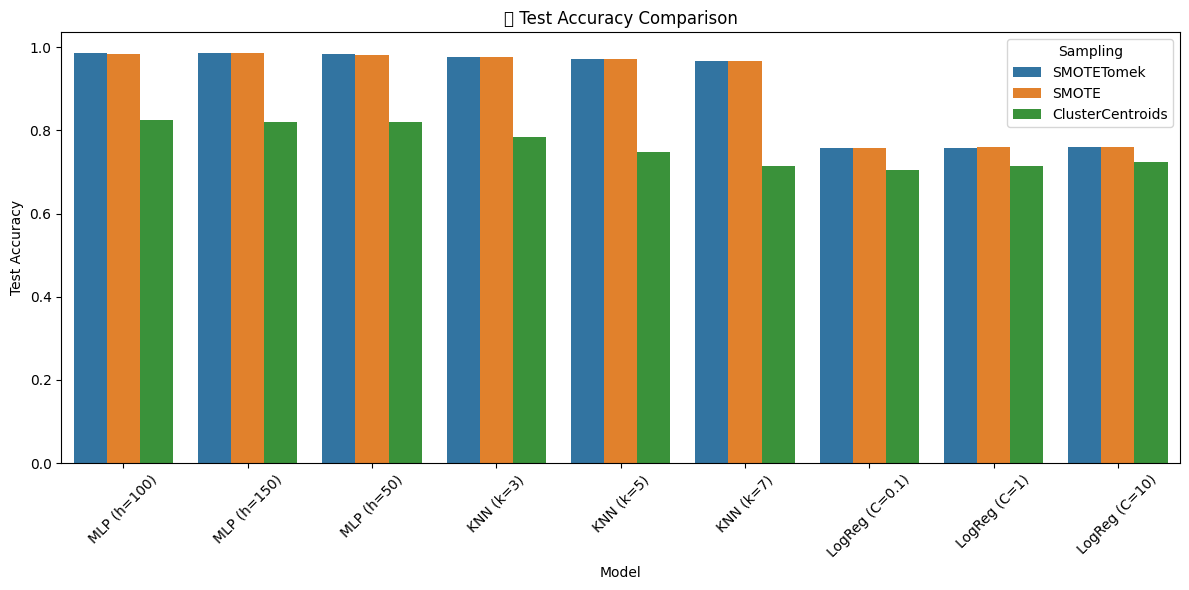

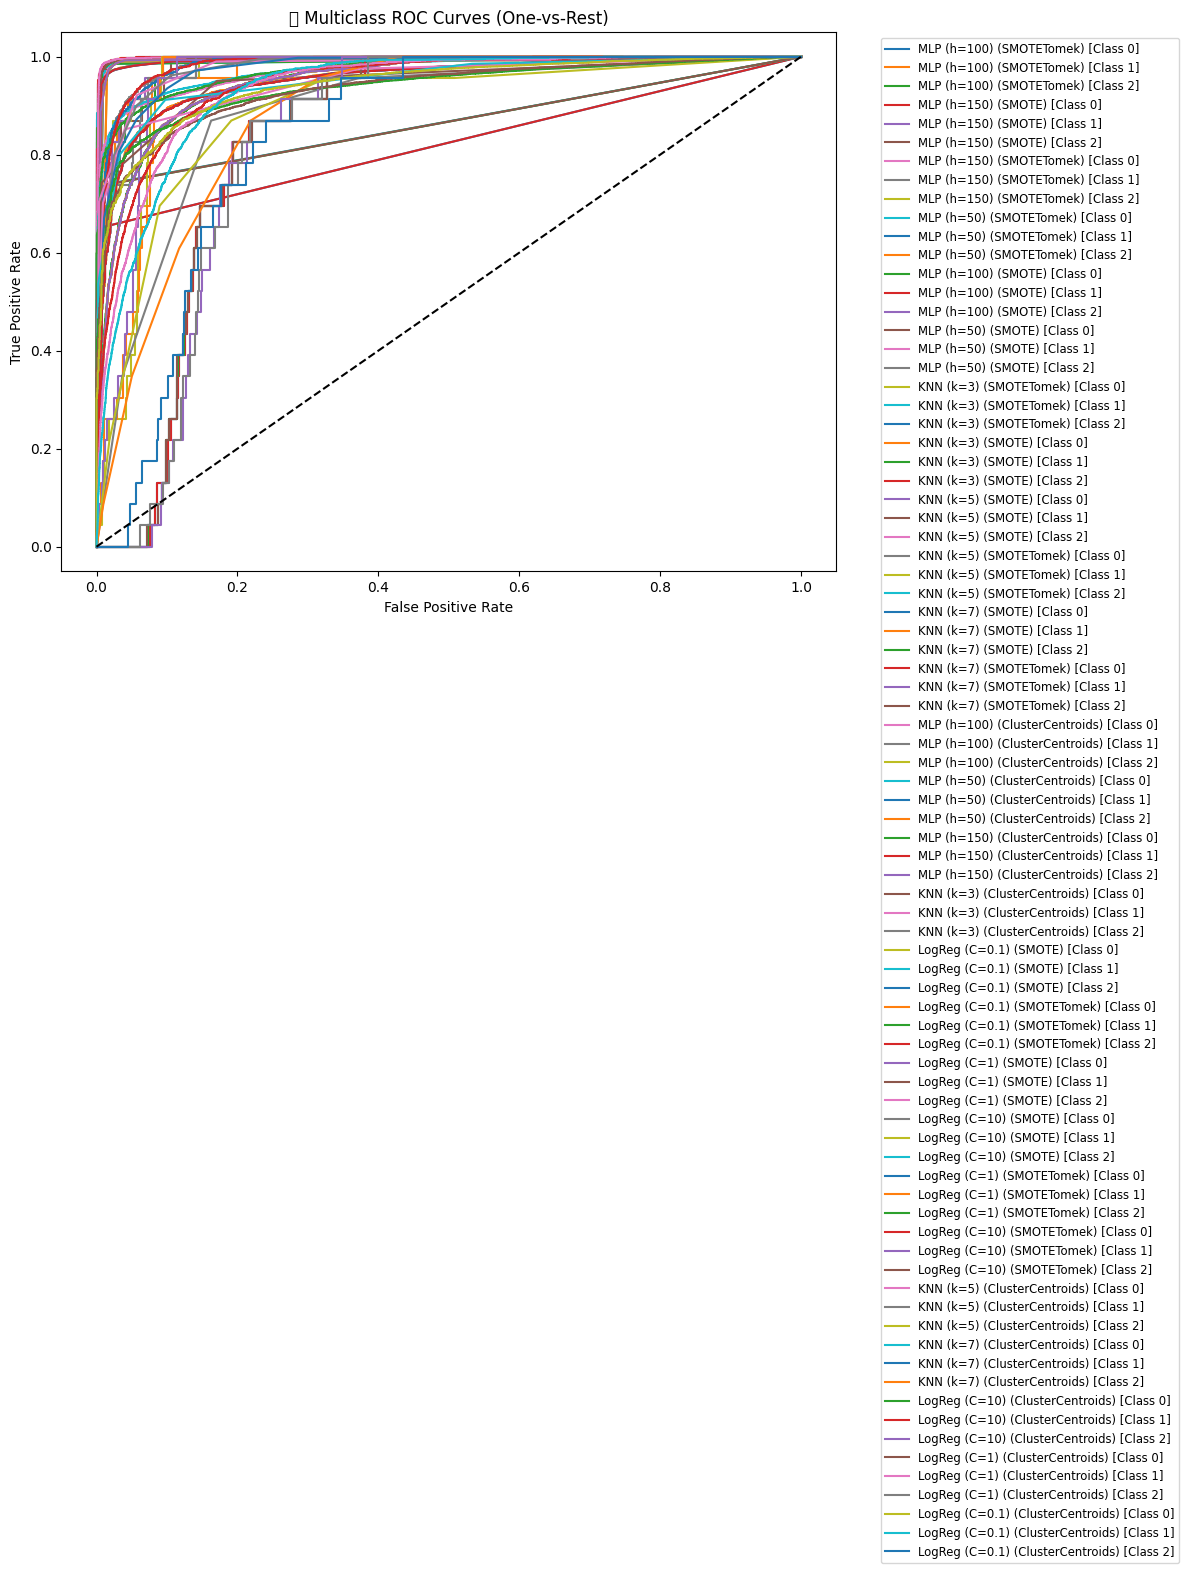


🔹 Confusion Matrices (Top 3 Models):


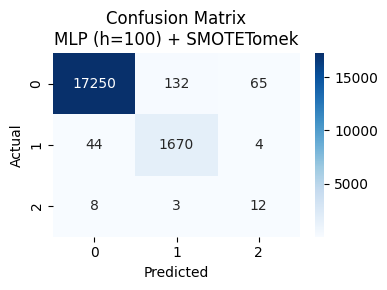

Classification Report for MLP (h=100) + SMOTETomek
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17447
           1       0.93      0.97      0.95      1718
           2       0.15      0.52      0.23        23

    accuracy                           0.99     19188
   macro avg       0.69      0.83      0.72     19188
weighted avg       0.99      0.99      0.99     19188


------------------------------------------------------------



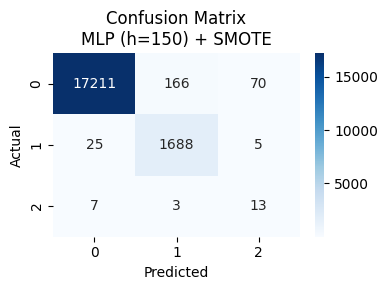

Classification Report for MLP (h=150) + SMOTE
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17447
           1       0.91      0.98      0.94      1718
           2       0.15      0.57      0.23        23

    accuracy                           0.99     19188
   macro avg       0.68      0.84      0.72     19188
weighted avg       0.99      0.99      0.99     19188


------------------------------------------------------------



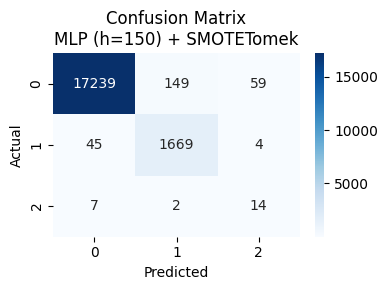

Classification Report for MLP (h=150) + SMOTETomek
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     17447
           1       0.92      0.97      0.94      1718
           2       0.18      0.61      0.28        23

    accuracy                           0.99     19188
   macro avg       0.70      0.86      0.74     19188
weighted avg       0.99      0.99      0.99     19188


------------------------------------------------------------

✅ Saved top model: MLP (h=100) with SMOTETomek


In [26]:

# Fix y shape if needed
if len(y.shape) > 1 and y.shape[1] > 1:
    y = np.argmax(y, axis=1)

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Use StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Define samplers
samplers = {
    "SMOTE": SMOTE(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42),
    "ClusterCentroids": ClusterCentroids(random_state=42)
}

# Step 4: Define models
def get_models():
    return {
        "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
        "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
        "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
        "LogReg (C=0.1)": LogisticRegression(C=0.1, max_iter=1000),
        "LogReg (C=1)": LogisticRegression(C=1, max_iter=1000),
        "LogReg (C=10)": LogisticRegression(C=10, max_iter=1000),
        "MLP (h=50)": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500),
        "MLP (h=100)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500),
        "MLP (h=150)": MLPClassifier(hidden_layer_sizes=(150,), max_iter=500),
    }

# Step 5: Train, evaluate, collect metrics
results = []

for sampler_name, sampler in samplers.items():
    X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)
    print(f"{sampler_name} class distribution:", dict(pd.Series(y_resampled).value_counts()))
    models = get_models()
    
    for model_name, model in models.items():
        model.fit(X_resampled, y_resampled)
        
        # Predictions
        y_pred_train = model.predict(X_resampled)
        y_pred_test = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else np.zeros((len(y_test), len(np.unique(y_resampled))))

        # Train metrics
        acc_train = accuracy_score(y_resampled, y_pred_train)
        prec_train = precision_score(y_resampled, y_pred_train, average='weighted', zero_division=0)
        rec_train = recall_score(y_resampled, y_pred_train, average='weighted', zero_division=0)
        f1_train = f1_score(y_resampled, y_pred_train, average='weighted', zero_division=0)

        # Test metrics
        acc = accuracy_score(y_test, y_pred_test)
        prec = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

        try:
            roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
        except:
            roc = None

        ll = log_loss(y_test, y_proba, labels=np.unique(y_test)) if y_proba is not None else np.nan

        results.append({
            "Sampling": sampler_name,
            "Model": model_name,
            "Train Accuracy": acc_train,
            "Train Precision": prec_train,
            "Train Recall": rec_train,
            "Train F1": f1_train,
            "Test Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            "ROC AUC": roc,
            "Log Loss": ll,
            "y_pred": y_pred_test,
            "y_proba": y_proba
        })

results_df = pd.DataFrame(results)

# Step 6: Normalize and rank by composite score
metrics = ["Test Accuracy", "Precision", "Recall", "F1", "ROC AUC"]
result_scaler = StandardScaler()
norm_metrics = result_scaler.fit_transform(results_df[metrics].fillna(0))
norm_df = pd.DataFrame(norm_metrics, columns=[f"{m} (norm)" for m in metrics])

# Normalize log loss inversely
ll_min = results_df["Log Loss"].min()
ll_max = results_df["Log Loss"].max()
results_df["Log Loss (norm)"] = 1 - (results_df["Log Loss"] - ll_min) / (ll_max - ll_min) if ll_max != ll_min else 0

# Combine normalized
combined_df = pd.concat([results_df, norm_df], axis=1)
combined_df["Composite Score"] = combined_df[
    [f"{m} (norm)" for m in metrics] + ["Log Loss (norm)"]
].mean(axis=1)

# Sort by best
combined_df = combined_df.sort_values(by="Composite Score", ascending=False).reset_index(drop=True)

# Step 7: Display summary
summary_cols = [
    "Sampling", "Model", 
    "Train Accuracy", "Train Precision", "Train Recall", "Train F1",
    "Test Accuracy", "Precision", "Recall", "F1", 
    "ROC AUC", "Log Loss", "Composite Score"
]
print("\n🔹 Ranked Model Performance Summary:")
display(combined_df[summary_cols])

# Step 8: Plot Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(data=combined_df, x="Model", y="Test Accuracy", hue="Sampling")
plt.title("🔹 Test Accuracy Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 9: Multiclass ROC Curve
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)

plt.figure(figsize=(10, 7))
for i, row in combined_df.iterrows():
    y_proba = row["y_proba"]
    
    if y_proba.shape[1] != len(classes):
        continue
    for class_idx in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, class_idx], y_proba[:, class_idx])
        plt.plot(fpr, tpr, label=f'{row["Model"]} ({row["Sampling"]}) [Class {classes[class_idx]}]')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🔹 Multiclass ROC Curves (One-vs-Rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize='small')
plt.tight_layout()
plt.show()

# Step 10: Confusion matrices
print("\n🔹 Confusion Matrices (Top 3 Models):")
for i in range(3):
    row = combined_df.iloc[i]
    cm = confusion_matrix(y_test, row["y_pred"])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix\n{row["Model"]} + {row["Sampling"]}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    print(f"Classification Report for {row['Model']} + {row['Sampling']}")
    print(classification_report(y_test, row["y_pred"]))
    print("\n" + "-"*60 + "\n")

# Step 11: Save top model and scaler
top_model = combined_df.iloc[0]
best_model_name = top_model["Model"]
best_sampler_name = top_model["Sampling"]
final_model = get_models()[best_model_name]
final_sampler = samplers[best_sampler_name]

X_resampled, y_resampled = final_sampler.fit_resample(X_train_scaled, y_train)
final_model.fit(X_resampled, y_resampled)

joblib.dump(final_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print(f"✅ Saved top model: {best_model_name} with {best_sampler_name}")

# STEP 5: PREDICT THE WEATHER HERE

In [26]:


# 🔹 Load model and scaler
model = joblib.load("best_model.pkl")
scaler = joblib.load("scaler.pkl")

# 🔹 Define the actual feature names
feature_names = [
    "Precip Type", "Temperature", "Apparent Temperature", 
    "Humidity", "Wind Speed", "Wind Bearing", 
    "Visibility", "Pressure" 
]

# 🔹 Function to get user input for features
def get_user_input():
    inputs = []
    print("Please enter values for the following features:")
    for feature in feature_names:
        while True:
            try:
                value = float(input(f"{feature}: "))
                inputs.append(value)
                break
            except ValueError:
                print(f"❌ Please enter a valid number for {feature}.")
    return np.array(inputs).reshape(1, -1)

# 🔹 Main function to make the prediction
def make_prediction():
    try:
        # Get user input
        X_input = get_user_input()

        # Apply the same scaling used during training
        X_scaled = scaler.transform(X_input)

        # Make prediction
        prediction = model.predict(X_scaled)
        predicted= prediction [0]


    
        if predicted == 0:
            print(colored("\n🌤️  Prediction: The weather is CLEAR", "green", attrs=["bold"]))
        elif predicted == 1:
            print(colored("\n⛅ Prediction: The weather is CLOUDY", "cyan", attrs=["bold"]))
        else:
            print(colored("\n🌧️  Prediction: The weather is RAINY", "blue", attrs=["bold"]))
    except Exception as e:
        print(colored("❌ Error during prediction: ", "red"), e)


if __name__ == "__main__":
    print("🌤️ Welcome to the Weather Prediction CLI!")
    make_prediction()


🌤️ Welcome to the Weather Prediction CLI!
Please enter values for the following features:


Precip Type:  0
Temperature:  1.11111
Apparent Temperature:  1.11111
Humidity:  0.9
Wind Speed:  15
Wind Bearing:  350
Visibility:  0
Pressure:  1008



⛅ Prediction: The weather is CLOUDY


# INVESTIGATING SPLIT RATIO EFFECT USING DIFFERENT SPLIT RATIOS


🔹 Evaluating Split Ratio: 70/30

🔹 Evaluating Split Ratio: 60/40

🔹 Evaluating Split Ratio: 50/50


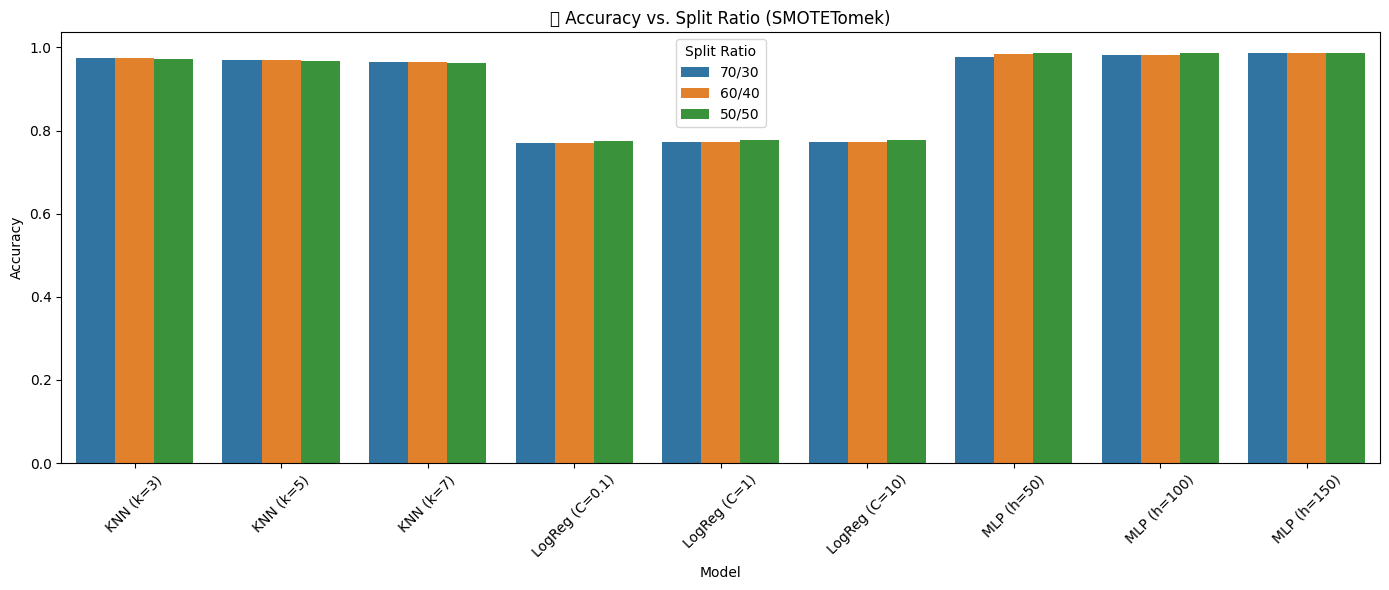

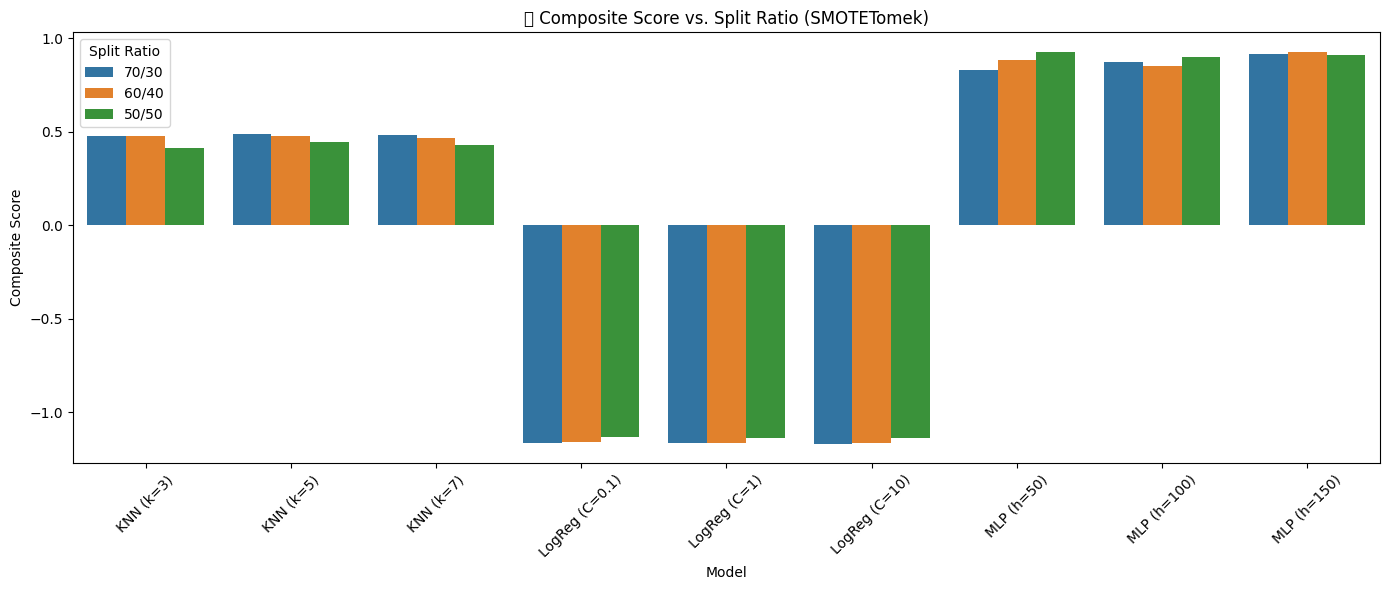


📊 Best Model for Split Ratio 70/30: MLP (h=150)


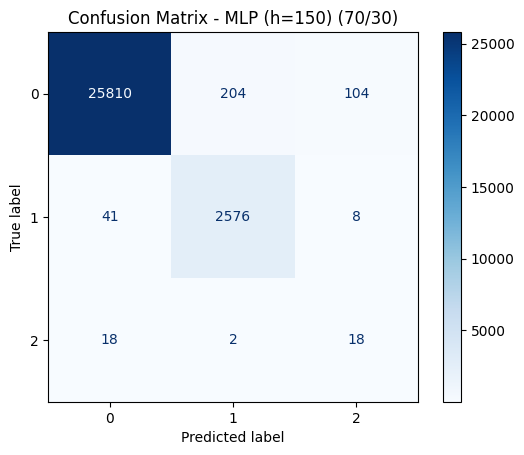

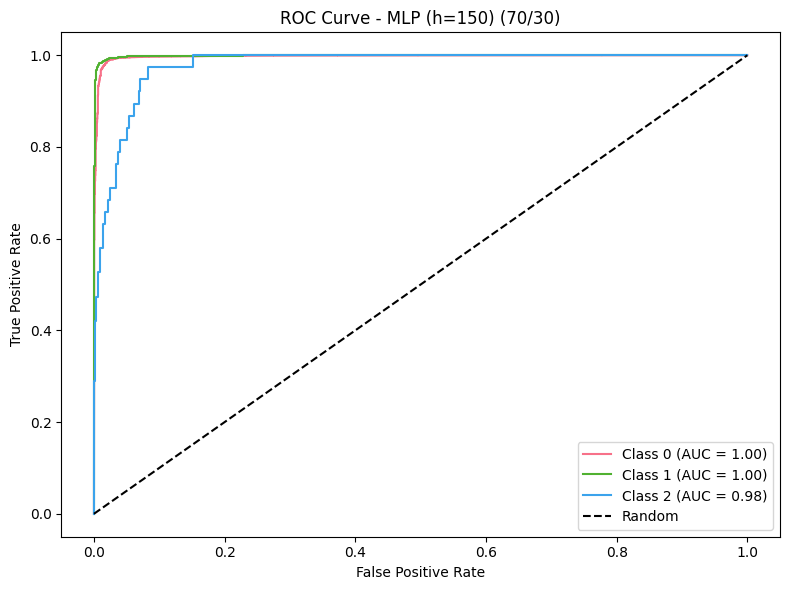


📊 Best Model for Split Ratio 60/40: MLP (h=150)


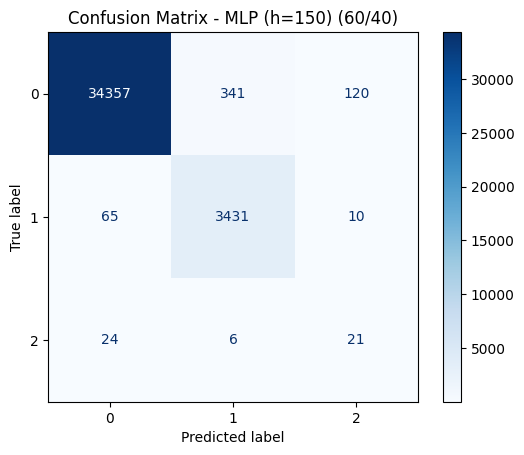

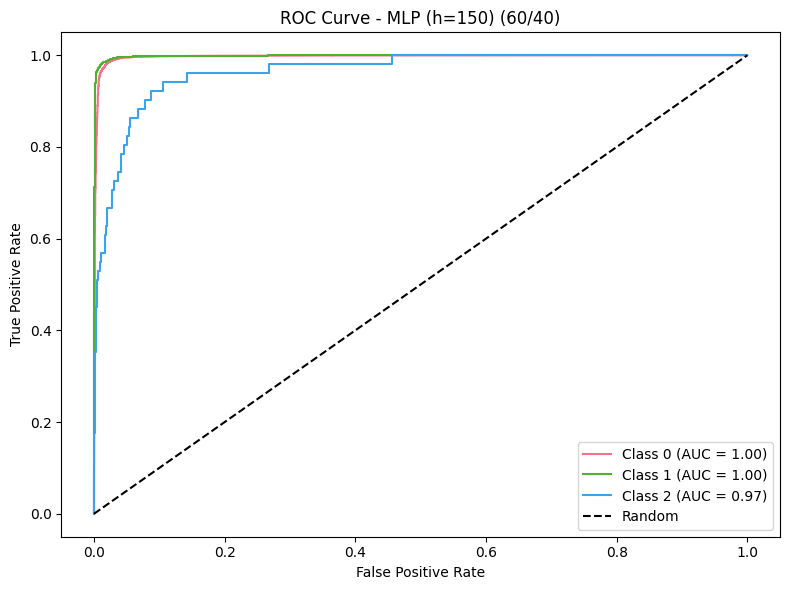


📊 Best Model for Split Ratio 50/50: MLP (h=50)


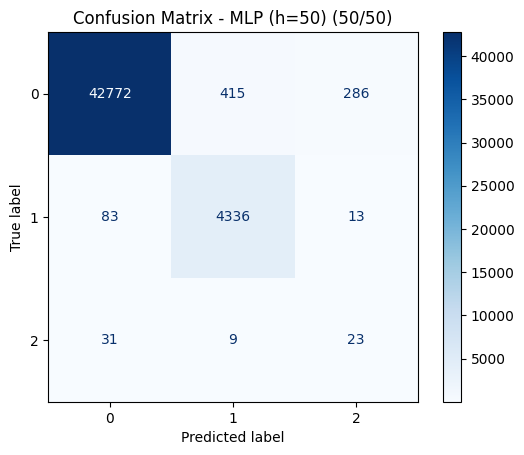

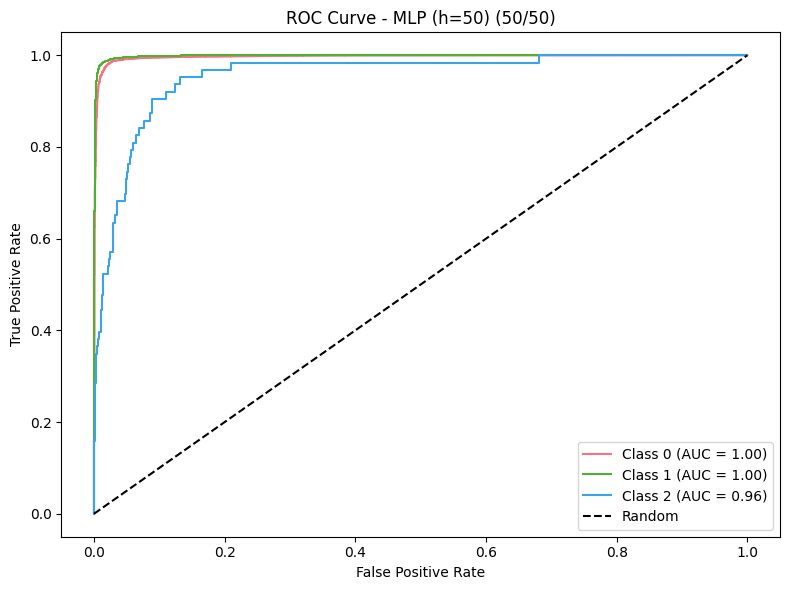

In [39]:


# Define the models
def get_models():
    return {
        "KNN (k=3)": KNeighborsClassifier(n_neighbors=3),
        "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
        "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
        "LogReg (C=0.1)": LogisticRegression(C=0.1, max_iter=1000),
        "LogReg (C=1)": LogisticRegression(C=1, max_iter=1000),
        "LogReg (C=10)": LogisticRegression(C=10, max_iter=1000),
        "MLP (h=50)": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500),
        "MLP (h=100)": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500),
        "MLP (h=150)": MLPClassifier(hidden_layer_sizes=(150,), max_iter=500),
    }

# Store results
results_split_ratio = []

# Define split ratios
split_ratios = [0.3, 0.4, 0.5]  # test sizes corresponding to 70/30, 60/40, 50/50

for test_size in split_ratios:
    split_label = f"{int((1 - test_size) * 100)}/{int(test_size * 100)}"
    print(f"\n🔹 Evaluating Split Ratio: {split_label}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTETomek sampling
    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

    # Train models
    models = get_models()
    for model_name, model in models.items():
        model.fit(X_resampled, y_resampled)
        y_pred_test = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else np.zeros((len(y_test), len(np.unique(y_test))))

        acc = accuracy_score(y_test, y_pred_test)
        prec = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)

        try:
            roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
        except:
            roc = None

        ll = log_loss(y_test, y_proba, labels=np.unique(y_test)) if y_proba is not None else np.nan

        results_split_ratio.append({
            "Split Ratio": split_label,
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1,
            "ROC AUC": roc,
            "Log Loss": ll
        })

# Create DataFrame
df_results = pd.DataFrame(results_split_ratio)

# Normalize metrics for comparison
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
scaler_norm = StandardScaler()
normed = scaler_norm.fit_transform(df_results[metrics].fillna(0))
normed_df = pd.DataFrame(normed, columns=[f"{m} (norm)" for m in metrics])
df_results = pd.concat([df_results, normed_df], axis=1)

# Normalize log loss inversely
ll_min, ll_max = df_results["Log Loss"].min(), df_results["Log Loss"].max()
df_results["Log Loss (norm)"] = 1 - (df_results["Log Loss"] - ll_min) / (ll_max - ll_min)

# Composite score
df_results["Composite Score"] = df_results[[f"{m} (norm)" for m in metrics] + ["Log Loss (norm)"]].mean(axis=1)

# Plots
plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="Model", y="Accuracy", hue="Split Ratio")
plt.title("🔹 Accuracy vs. Split Ratio (SMOTETomek)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(data=df_results, x="Model", y="Composite Score", hue="Split Ratio")
plt.title("🔹 Composite Score vs. Split Ratio (SMOTETomek)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Confusion Matrices and ROC Curves for best model per split
for split_ratio in df_results["Split Ratio"].unique():
    best_row = df_results[df_results["Split Ratio"] == split_ratio].sort_values("Composite Score", ascending=False).iloc[0]
    model_name = best_row["Model"]
    print(f"\n📊 Best Model for Split Ratio {split_ratio}: {model_name}")

    # Redo train-test split
    test_size = int(split_ratio.split("/")[1]) / 100
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    smote_tomek = SMOTETomek(random_state=42)
    X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

    # Train best model
    model = get_models()[model_name]
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    y_score = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else None

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name} ({split_ratio})")
    plt.show()

    # ROC Curve (if supported)
    if y_score is not None:
        y_test_bin = label_binarize(y_test, classes=np.unique(y))
        n_classes = y_test_bin.shape[1]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot ROC Curve
        plt.figure(figsize=(8, 6))
        colors = sns.color_palette("husl", n_classes)
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label="Random")
        plt.title(f"ROC Curve - {model_name} ({split_ratio})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()


# EXTENSION (HYPERPARAMETER TUNING)

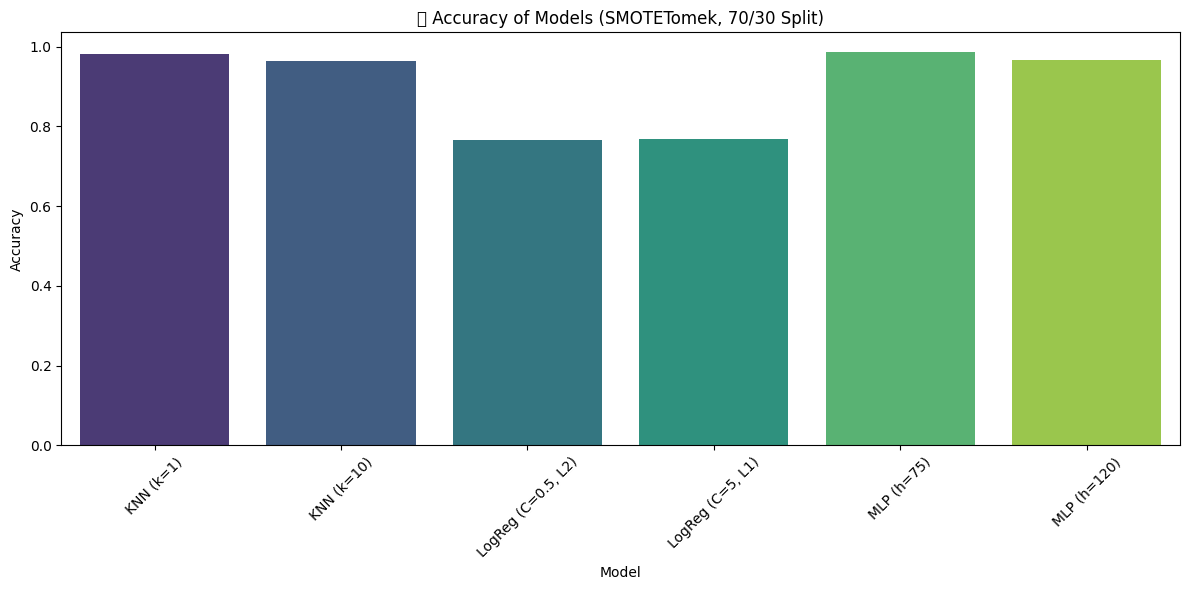

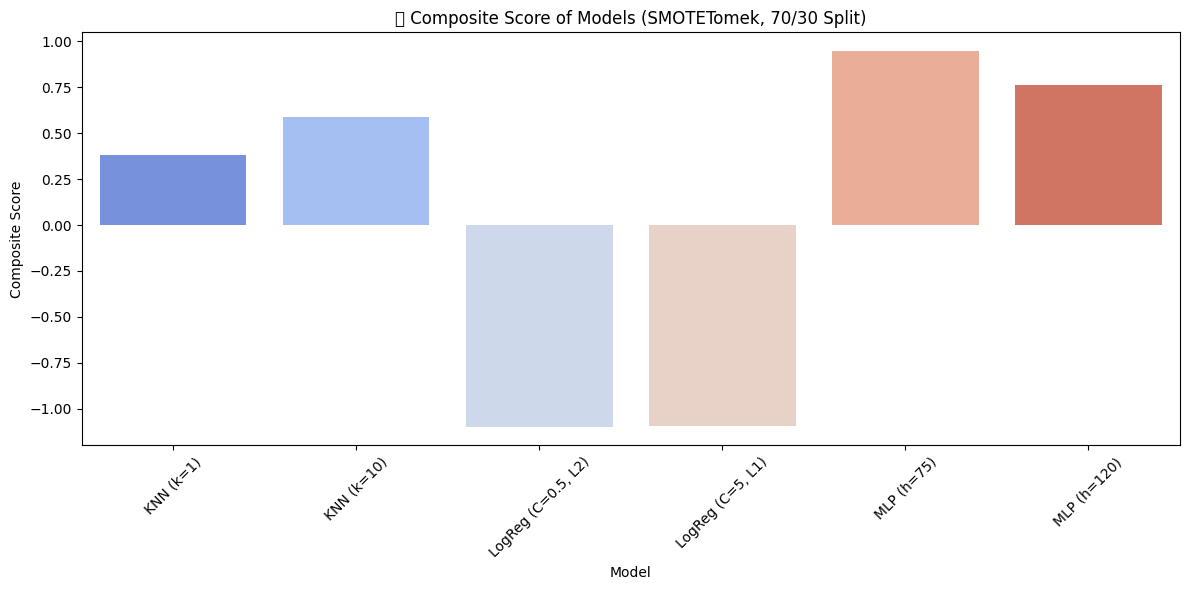

In [40]:


# 🟩 Replace this with your actual feature matrix X and target vector y
# X, y = ...

# Define alternative hyperparameters for models
def get_alt_models():
    return {
        "KNN (k=1)": KNeighborsClassifier(n_neighbors=1),
        "KNN (k=10)": KNeighborsClassifier(n_neighbors=10),
        "LogReg (C=0.5, L2)": LogisticRegression(C=0.5, penalty='l2', solver='liblinear', max_iter=1000),
        "LogReg (C=5, L1)": LogisticRegression(C=5, penalty='l1', solver='liblinear', max_iter=1000),
        "MLP (h=75)": MLPClassifier(hidden_layer_sizes=(75,), activation='tanh', solver='adam', max_iter=500),
        "MLP (h=120)": MLPClassifier(hidden_layer_sizes=(120,), activation='relu', solver='sgd', learning_rate='adaptive', max_iter=500),
    }

# Train-test split (standard 70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

# Train models
models = get_alt_models()
results = []

for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else np.zeros((len(y_test), len(np.unique(y_test))))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    try:
        roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    except:
        roc = None

    ll = log_loss(y_test, y_proba, labels=np.unique(y_test)) if y_proba is not None else np.nan

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc,
        "Log Loss": ll
    })

# Create DataFrame
df_alt_results = pd.DataFrame(results)

# Normalize metrics for composite score (excluding Log Loss)
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
scaler_norm = StandardScaler()
normed = scaler_norm.fit_transform(df_alt_results[metrics].fillna(0))
normed_df = pd.DataFrame(normed, columns=[f"{m} (norm)" for m in metrics])
df_alt_results = pd.concat([df_alt_results, normed_df], axis=1)

# Normalize log loss inversely
ll_min, ll_max = df_alt_results["Log Loss"].min(), df_alt_results["Log Loss"].max()
df_alt_results["Log Loss (norm)"] = 1 - (df_alt_results["Log Loss"] - ll_min) / (ll_max - ll_min)

# Compute Composite Score
df_alt_results["Composite Score"] = df_alt_results[[f"{m} (norm)" for m in metrics] + ["Log Loss (norm)"]].mean(axis=1)

# Plot Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(data=df_alt_results, x="Model", y="Accuracy", palette="viridis")
plt.title("🔸 Accuracy of Models (SMOTETomek, 70/30 Split)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Composite Score
plt.figure(figsize=(12, 6))
sns.barplot(data=df_alt_results, x="Model", y="Composite Score", palette="coolwarm")
plt.title("🔸 Composite Score of Models (SMOTETomek, 70/30 Split)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# EXTENSION (TRY DIFFERENT ALGORITHMS)

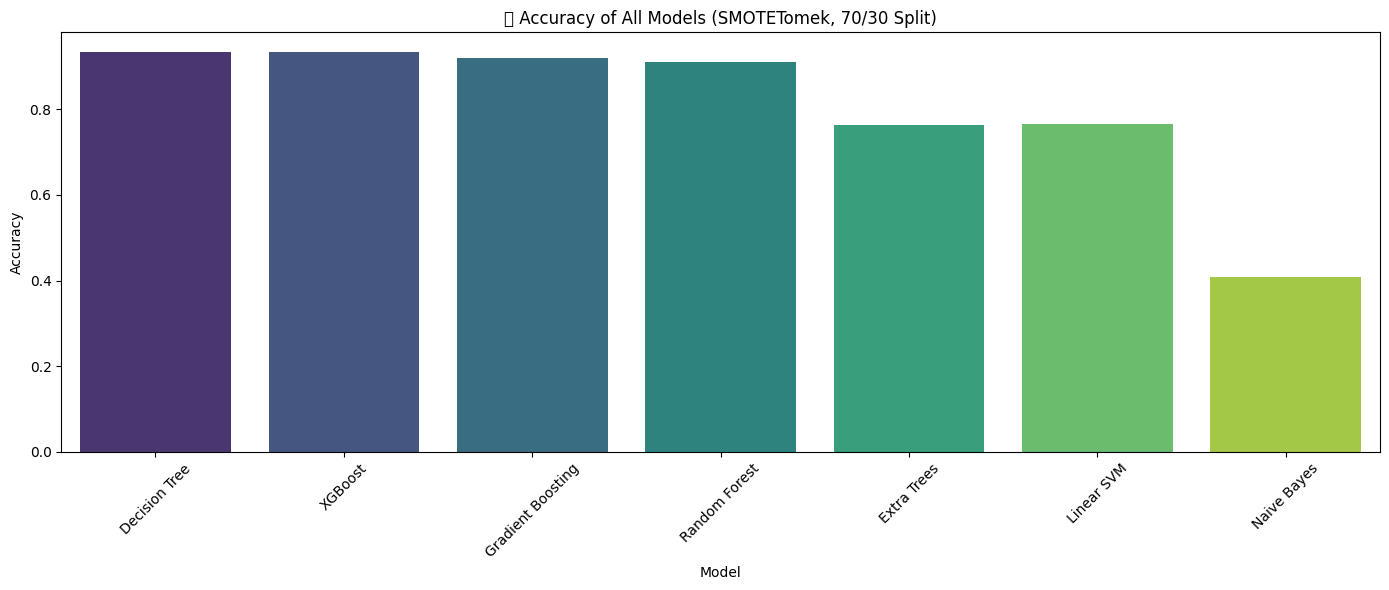

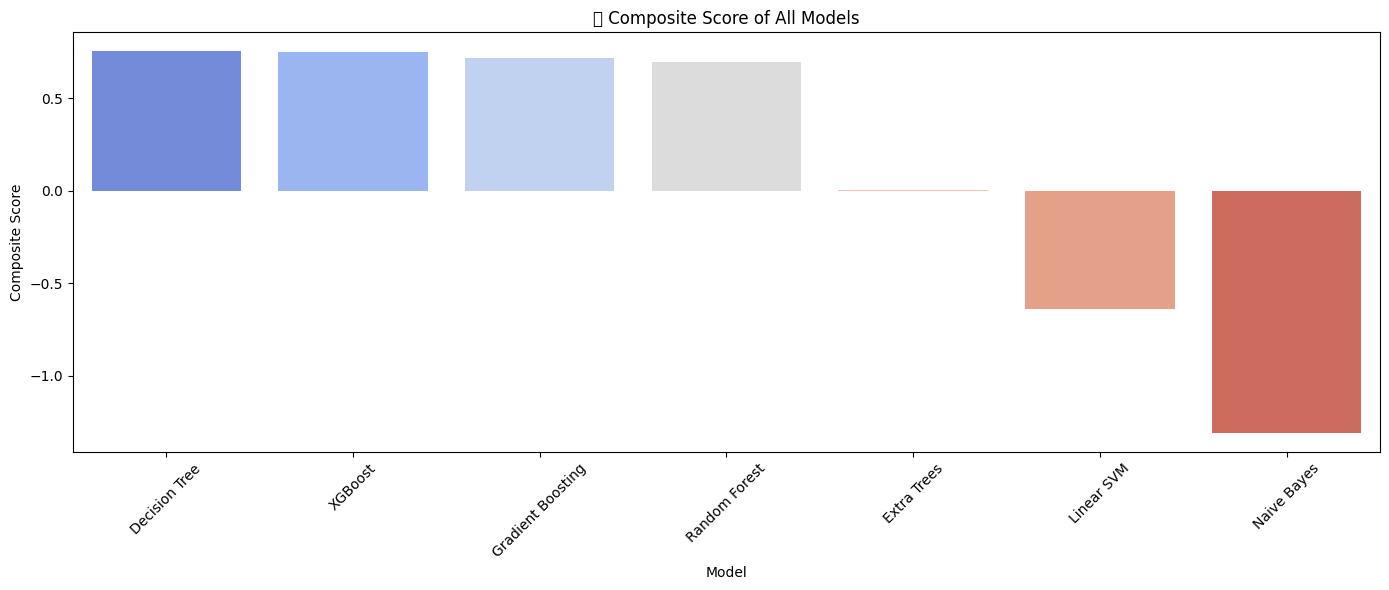

In [44]:
def get_extended_models():
    return {
        "Naive Bayes": GaussianNB(),
        "Decision Tree": DecisionTreeClassifier(max_depth=5),
        "Extra Trees": ExtraTreesClassifier(n_estimators=20, max_depth=5, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=20, max_depth=3, learning_rate=0.1, random_state=42),
        "XGBoost": xgb.XGBClassifier(n_estimators=20, max_depth=3, use_label_encoder=False, eval_metric='mlogloss', verbosity=0),
        "Linear SVM": LinearSVC(max_iter=1000, dual=False)
    }

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train_scaled, y_train)

# Train models and evaluate
models = get_extended_models()
results = []

for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled) if hasattr(model, "predict_proba") else np.zeros((len(y_test), len(np.unique(y_test))))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    try:
        roc = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    except:
        roc = None

    ll = log_loss(y_test, y_proba, labels=np.unique(y_test)) if y_proba is not None else np.nan

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc,
        "Log Loss": ll
    })

# Create DataFrame
df_ext_results = pd.DataFrame(results)

# Normalize metrics
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
normed = StandardScaler().fit_transform(df_ext_results[metrics].fillna(0))
normed_df = pd.DataFrame(normed, columns=[f"{m} (norm)" for m in metrics])
df_ext_results = pd.concat([df_ext_results, normed_df], axis=1)

# Normalize Log Loss (inverted)
ll_min, ll_max = df_ext_results["Log Loss"].min(), df_ext_results["Log Loss"].max()
df_ext_results["Log Loss (norm)"] = 1 - (df_ext_results["Log Loss"] - ll_min) / (ll_max - ll_min)

# Composite Score
df_ext_results["Composite Score"] = df_ext_results[[f"{m} (norm)" for m in metrics] + ["Log Loss (norm)"]].mean(axis=1)

# Sort by Composite Score
df_ext_results.sort_values("Composite Score", ascending=False, inplace=True)

# 📊 Plot Accuracy
plt.figure(figsize=(14, 6))
sns.barplot(data=df_ext_results, x="Model", y="Accuracy", palette="viridis")
plt.title("🔹 Accuracy of All Models (SMOTETomek, 70/30 Split)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📊 Plot Composite Score
plt.figure(figsize=(14, 6))
sns.barplot(data=df_ext_results, x="Model", y="Composite Score", palette="coolwarm")                             
plt.title("🔹 Composite Score of All Models")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
